## Intrdouction
This tutorial will introduce you to some basic methods for crawling data, particularly focusing on JavaScript generated data. Recent years, frond-end rendering becomes more and more common and popoular. But this makes crwaling data harder because target data is not always in raw response from server, it may come from data APIs (the APIs maybe are not public on their developer books) calling by JavaScript and then be rendered by JavaScript, so bascially we have 3 ways to crawl those kind of data.
1. Read through JavaScript part to find out usages of data APIs. 
2. Sniffer network traffics to find data API requests and analyze theris usages from requests.
3. Render generated content by running JavaScript and extract data from rendered content.

In this tutorial, we are going to use some basic popular technology of 3 to crawl some laughy GIFs. A example of our targets:
![<img srf="https://i.giphy.com/media/1fhbuQp6comAgYSr8j/giphy.webp">](https://i.giphy.com/media/1fhbuQp6comAgYSr8j/giphy.webp)

### Tutorial Content
In this tutorial, we will show how to do some basic crawling in Python, specifically using [Scarpy](https://scrapy.org/), [Splash](https://splash.readthedocs.io) and [Selenium](http://selenium-python.readthedocs.io/).

We'll crawl trending GIFs with names and tags on [GIPHY](https://giphy.com/). While GIPHY provide developer APIs, their developer APIs don't respond tags of GIFs, and just using APIs they provide is not our purpose as well.

We will cover the following topics in this tutorial:
- [Installing the libraries](#Installing-the-libraries)
- [Selenium](#Selenium)
- [Crawling trending GIFs](#Crawling-trending-GIFs)
- [Splash](#Splash)
- [Crawling Name](#Crawling-Name)

## Installing the libraries

Before getting started, you'll need to install the various libraries that we will use. You can install Scarpy, Sle using `pip`:
            
    $ pip install scrapy
    
Or using `conda`:
    
    $ conda install -c conda-forge scrapy 

If your platform is Windows, you may get `error: Microsoft Visual C++ 14.0 is required`, then you can visit [Visual Cpp Build Tools](http://landinghub.visualstudio.com/visual-cpp-build-tools) to download the required library (`Microsoft Visual C++ 14.0` refers `VC++ 2015.3 v140 toolset for desktop (x86,x64)` in the install options).

And you also need Splash, to install Splash, you need:

1.    Install [docker](https://www.docker.com/).

2.    Pull the image, for Linux users:

    $ sudo docker pull scrapinghub/splash
    
    For other users:
    
    $ docker pull scrapinghub/splash
    
3.    Start the container, for Linux users:

    $ sudo docker run -p 8050:8050 -p 5023:5023 scrapinghub/splash
    
    For other users:
    
    $ docker run -p 8050:8050 -p 5023:5023 scrapinghub/splash

4. Splash is now available at 0.0.0.0 at ports 8050 (http) and 5023 (telnet).

To use Scrapy with Splash, you need install scrapy-splash, you can install it using `pip`:

    $ pip install scrapy-splash
    
What's more, you need Selenium when you need to interact with pages. You can install it using `pip`:

    $ pip install selenium
    
Selenium requires a driver to interface with the chosen browser, more details at http://selenium-python.readthedocs.io/installation.html#drivers. In this tutorial, you will use Chrome.

## Selenium

The introduction of Selenium on Wikipedia is:

> Selenium is a portable software-testing framework for web applications. Selenium provides a playback (formerly also recording) tool for authoring tests without the need to learn a test scripting language (Selenium IDE). It also provides a test domain-specific language (Selenese) to write tests in a number of popular programming languages, including C#, Groovy, Java, Perl, PHP, Python, Ruby and Scala. The tests can then run against most modern web browsers. Selenium deploys on Windows, Linux, and macOS platforms. It is open-source software, released under the Apache 2.0 license: web developers can download and use it without charge.

For our usage, Selenium is like a command-line browser. You can control this browser with Python. Let's try it with a GIPHY page, https://giphy.com/gifs/26BGqo0GoLb0ThsXu.

In [1]:
from selenium import webdriver
driver = webdriver.Chrome()

After running above cell, there should be a new Chrome window with "Chrome is being controlled by automated test software" poping up. Let's try to control this Chrome window with Python.

In [2]:
driver.get("https://giphy.com/gifs/26BGqo0GoLb0ThsXu")

Now you can see the Chrome windows is visiting https://giphy.com/gifs/26BGqo0GoLb0ThsXu. And we can get the content of the Chrome window as image in our Jupyter Notebook.

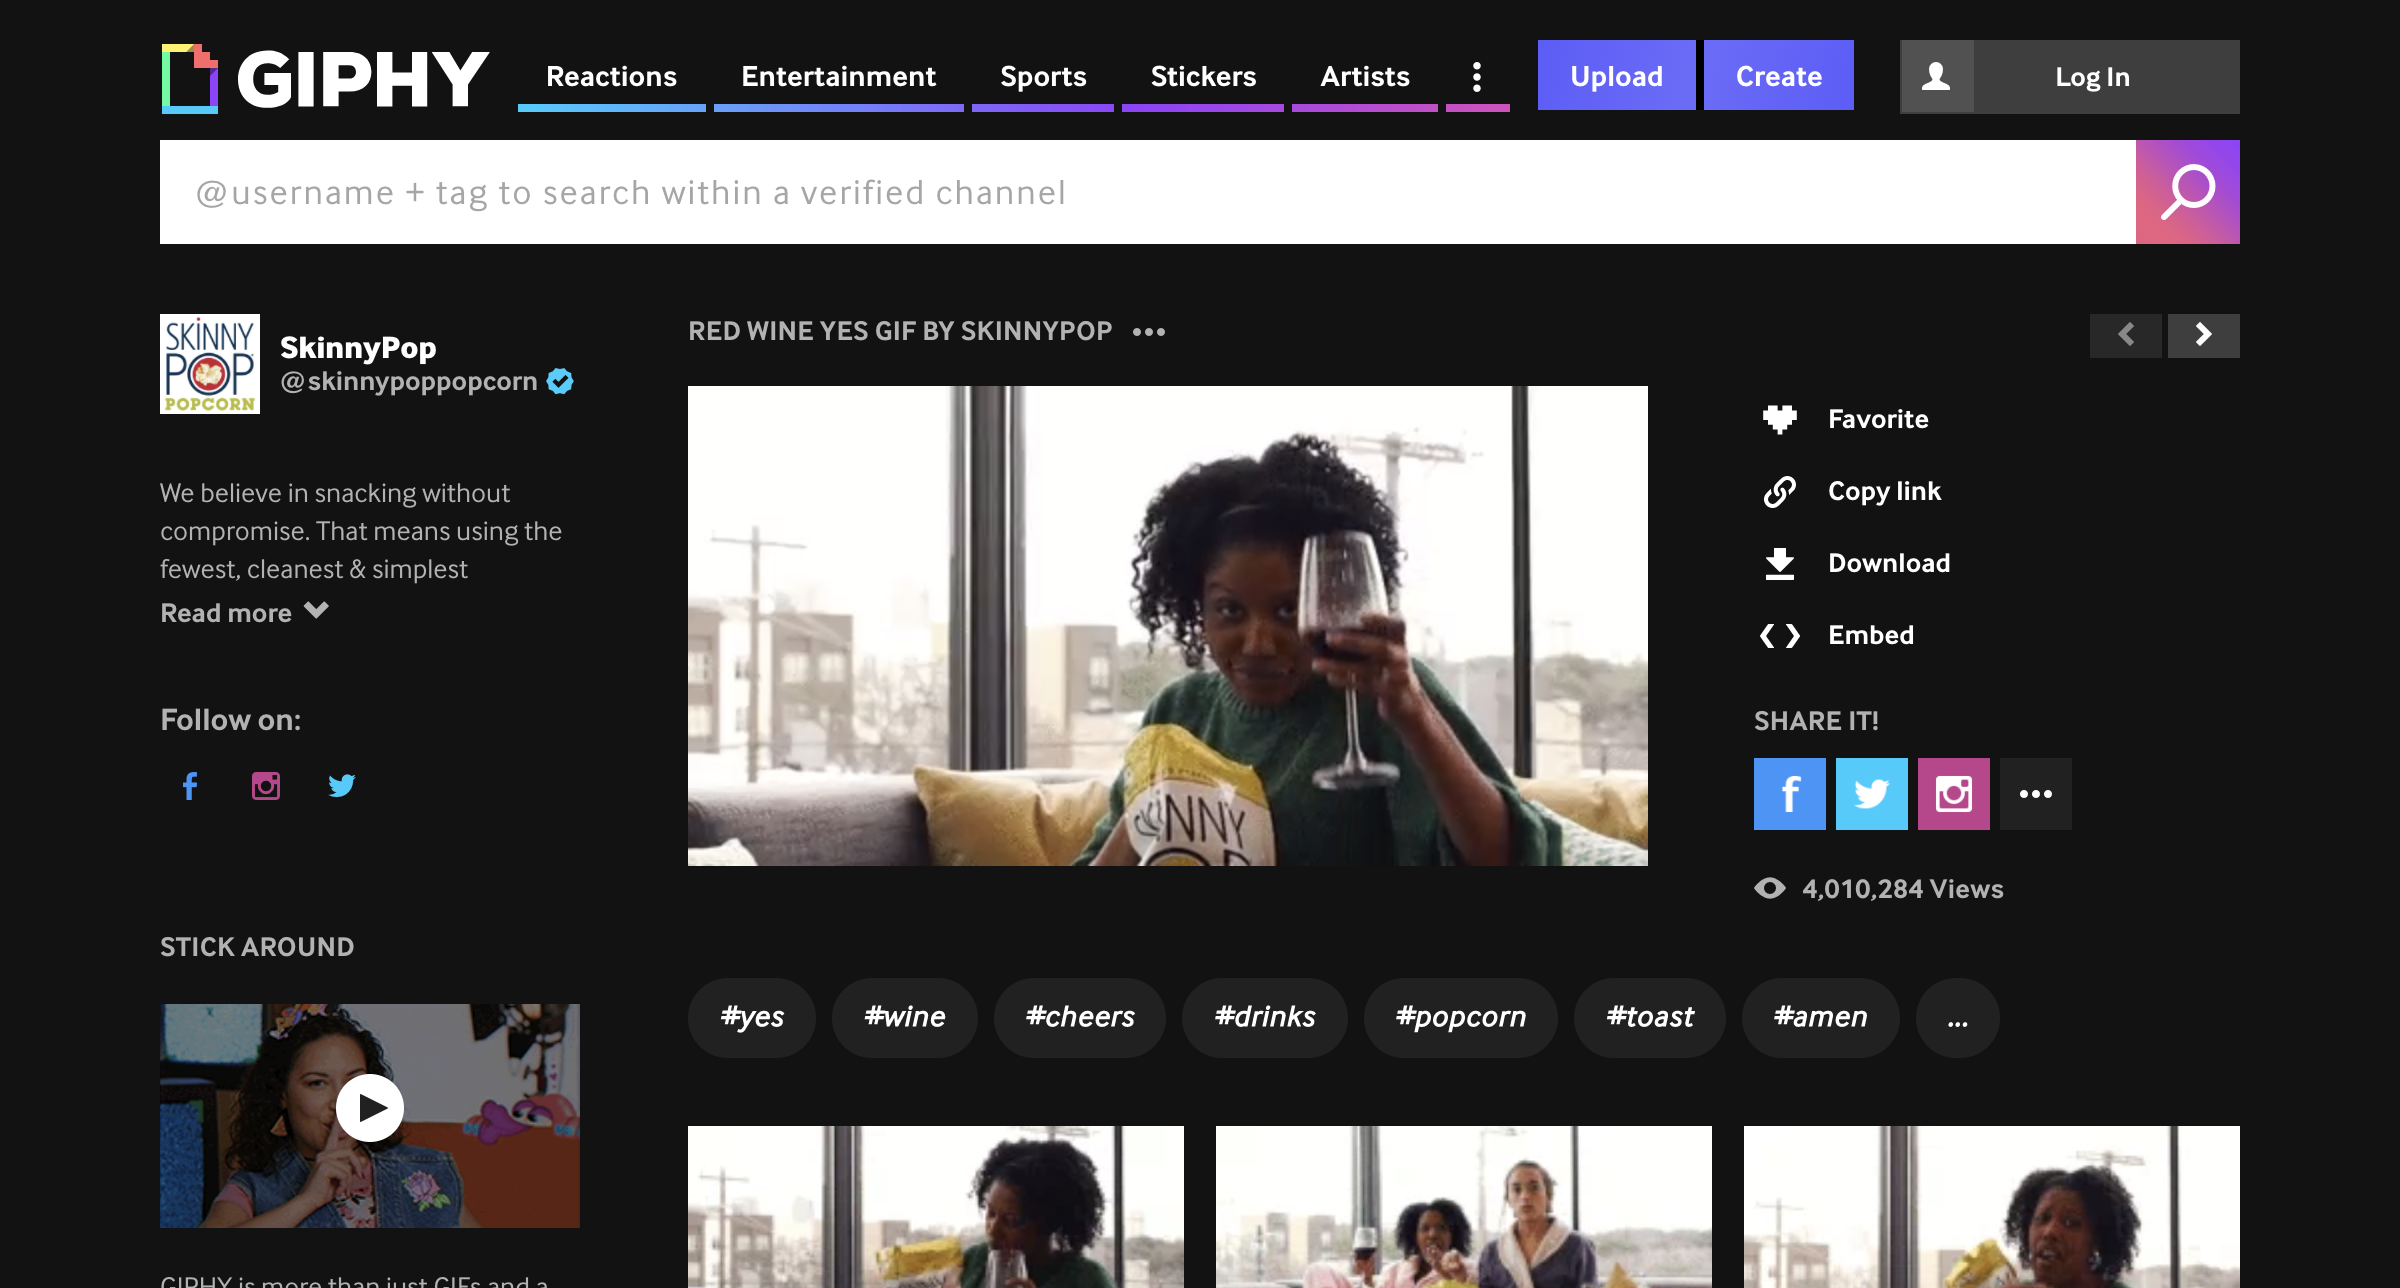

In [3]:
from IPython.display import Image
Image(data=driver.get_screenshot_as_png())

You can also get the current source of the page.

In [4]:
driver.page_source

'<!DOCTYPE html><html xmlns="http://www.w3.org/1999/xhtml" itemscope="" itemtype="http://schema.org/WebPage" class=" js flexbox flexboxlegacy no-touch geolocation history websockets rgba hsla multiplebgs backgroundsize borderimage borderradius boxshadow textshadow opacity cssanimations csscolumns cssgradients cssreflections csstransforms csstransforms3d csstransitions fontface generatedcontent localstorage sessionstorage applicationcache fullscreen"><head>\n      <title>Red Wine Yes GIF by SkinnyPop - Find &amp; Share on GIPHY</title>\n\n      <meta charset="utf-8" />\n      <meta http-equiv="X-UA-Compatible" content="IE=edge,chrome=1" />\n      <meta name="google-site-verification" content="8mfne8CLOmysP4fUdGDJioWLEGbHMJY4tBsxsQT2eSY" />\n      <meta name="msvalidate.01" content="F8A7FDC3D369E857ACB67C4AB8EBD9A4" />\n      <meta name="alexaVerifyID" content="HMyPJIK-pLEheM5ACWFf6xvnA2U" />\n      <meta property="fb:admins" content="548288355" />\n      <meta name="p:domain_verify" con

What's more, you can interact with the page.

In [5]:
# Scroll the page to the bottom using JavaScript
driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")

One important thing to crawl data is to sum up ruls of target data, the rules may be not true, but we can fix them when we find them wrong. By visiting several GIF pages on GIPHY, we can summarize some useful rules for us to crawl data:
1. Every GIF has an id, for the GIF page we are visiting, it is `26BGqo0GoLb0ThsXu`. For a GIF, its page url is https://giphy.com/gifs/&lt;id&gt;/.
2. The name of a GIF is on left above the GIF on the GIF page. For the GIF page we are visiting, it is `RED WINE YES GIF BY SKINNYPOP`.
3. There are some tags of a GIF, which are below the GIF on the GIF page. For the GIF page we are visiting, the tags are `#yes, #wine, #cheers, #drinks, #popcorn, #toast, #amen, #red wine, #wine glass, #to you, #skinnypop, #more wine, #i'll toast that, #i'll cheers to that`.

So for our task, the items of data we want to crawl are in the format, `{id:<id>, name:<name>, tags:[<tag1>, <tag2>, …]}`. You may add some more fields if you want, but in this tutorial we just cover these fields.

In [6]:
driver.close()

After finishing our task, remeber to close WebDriver. 

## Crawling trending GIFs

Then let's crawl some data with our powerful Selenium. On homepage of GIPHY, there are trending GIFs. It will load some of GIFs and load more GIFs when you scroll to bottom. Using Selenium, it's pretty easy to simulate these operations. But we have another important thing to do, it's to figure out the location of our target data tag. In this tutorial, we will use [XPath](https://www.w3schools.com/xml/xpath_intro.asp) to locate target tags.

To find the path of target tags, we may use `Insepctor Tool` (most mainstream browser have it). Right click the element you want to get path, then choose `insepct`, you can get the path of the tag of the elemnt in `Insepctor`. For our task, the XPath of the tag contain all GIFs' tags is below:

In [7]:
GIFS_DIV_XPATH = "/html/body/div[@id='content']//section[@class='homepage-content clearfix']/*[1]/*[1]/*[1]/*[2]/*[2]/*[1]/*[2]"

Then we can use Selenium to keep scrolling down until we get enough GIFs.

In [8]:
import time
from lxml import html

# Wait 5 seconds to load the page
GET_PAUSE_TIME = 5.0
# Wait 5 seconds after scrolling to bottom to load new GIFs
SCROLL_PAUSE_TIME = 5.0

options = webdriver.ChromeOptions()
# We don't really need to GIF files, we just need GIFs' ids, so we disable image to accelerate loading
# Ref: http://tarunlalwani.com/post/selenium-disable-image-loading-different-browsers/
prefs = {"profile.managed_default_content_settings.images":2}
options.add_experimental_option("prefs",prefs)
# Run Chrome in headless mode, it will make crawling faster and take less memory
# In headless mode, there will not be a Chrome window, all things happen quietly
options.add_argument('headless')
driver = webdriver.Chrome(chrome_options=options)

url = 'https://giphy.com/'
driver.get(url)
time.sleep(GET_PAUSE_TIME)

# The number of GIFs we'd like to crawl
TARGET_GIF_NUM = 100

while True:
    # Using lxml to parse html tree and get the tag
    tree = html.fromstring(driver.page_source)
    gifs_div = tree.xpath(GIFS_DIV_XPATH)[0]
    if len(gifs_div.getchildren()) >= TARGET_GIF_NUM:
        break
    driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
    time.sleep(SCROLL_PAUSE_TIME)
driver.close()

By analyzing content of the tag, we can find urls of GIF pages and tags of GIFs are in the tag, but there is no name in the tag. What's more, we find the rule we summarize before is uncorrect. The url of GIF pages can be https://giphy.com/gifs/&lt;id&gt;/ or https://giphy.com/gifs/&lt;name&gt;-&lt;id&gt;/, we need notice this when we extract ids of GIFs. Since there may be two formats of GIF urls, we can always get the GIF page with url https://giphy.com/gifs/&lt;id&gt;/. For example, the url of GIF page of a GIF on homepage is https://giphy.com/gifs/afvbabies-babies-afv-easter-bunny-26BkMEseNz2YaHEHK, we can still visit its GIF page by https://giphy.com/gifs/26BkMEseNz2YaHEHK.

In [9]:
def extract_id_and_tag_from_GIF_div(gif_div):
    id_div = gif_div.xpath("./*[1]/*[1]")[0]
    gif_id = id_div.attrib['href'].split('-')[-1].split('/')[-1]
    tags_div = gif_div.xpath("./*[1]/*[3]")[0]
    gif_tags = list(map(lambda x: x.text, tags_div.getchildren()))
    return {'id': gif_id, 'tags': gif_tags}

crawl_data = list(map(extract_id_and_tag_from_GIF_div, gifs_div))
print(crawl_data[:10])

[{'id': 'hTDNwZbCwOfrmUItSU', 'tags': ['love', 'animation', 'cute', 'cartoon', 'jump', 'animal', 'drawing', 'bunny', 'rabbit', 'spring', 'easter', 'hearts', 'hop', 'easter bunny']}, {'id': 'SiGHSINUWUUDKnzYKI', 'tags': ['funny', 'lol', 'laughing', 'chicken', 'lmao', 'easter', 'joke', 'egg', 'chick', 'crack', 'chocron', 'crack up']}, {'id': 'NQURqeViHYGTPHdbb3', 'tags': ['happy', 'animated', 'loop', 'bunny', 'easter', 'chicks', 'joonasjoonas', 'estinkg']}, {'id': 'l2R00wfa8fttlpRPG', 'tags': ['dance', 'happy', 'easter', 'egg', 'april', 'happy easter', 'easter egg', 'lisa vertudaches', 'long weekend', 'easter sunday', 'chocolate egg', 'painted egg', 'easter excitement']}, {'id': '3osxYlGmgVHXNYtVWo', 'tags': ['gif', 'cute', 'bunny', 'easter', 'eggs', 'happy easter', 'easter bunny', 'storks', 'cute gif', 'easter eggs']}, {'id': 'xUA7aMbMhX6ecZaxZS', 'tags': ['animation', 'cute', 'cartoon', 'kids', 'easter', 'dinosaur', 'happy easter', 'joey ahlbum', 'lucy the dinosaur', 'fredbot']}, {'id'

## Splash

We have ids and tags of GIFs now, then we need crawl the names of these GIFs. But before we start crawling names, let's intrdouce another popular tool to handle JaveScript generated content, Splash. Splash is a javascript rendering service. It’s a lightweight web browser with an HTTP API. Why we need Splash since we already have Selenium? There are some discussions about it on [here](https://www.reddit.com/r/Python/comments/2xp5mr/handling_javascript_in_scrapy_with_splash/). 

Let's go through a simple example to see Splash's usage directly. First, let's start a JavaScript disabled Selenium with Chrome backend to see the difference between raw response and Splash rendered HTML of https://giphy.com/gifs/26uf6iTwBsFJFX6PS.

In [10]:
options = webdriver.ChromeOptions()
prefs = {'profile.managed_default_content_settings.javascript': 2}
options.add_experimental_option("prefs", prefs)
options.add_argument('headless')
driver = webdriver.Chrome(chrome_options=options)

Then let's see what the raw response looks like: 

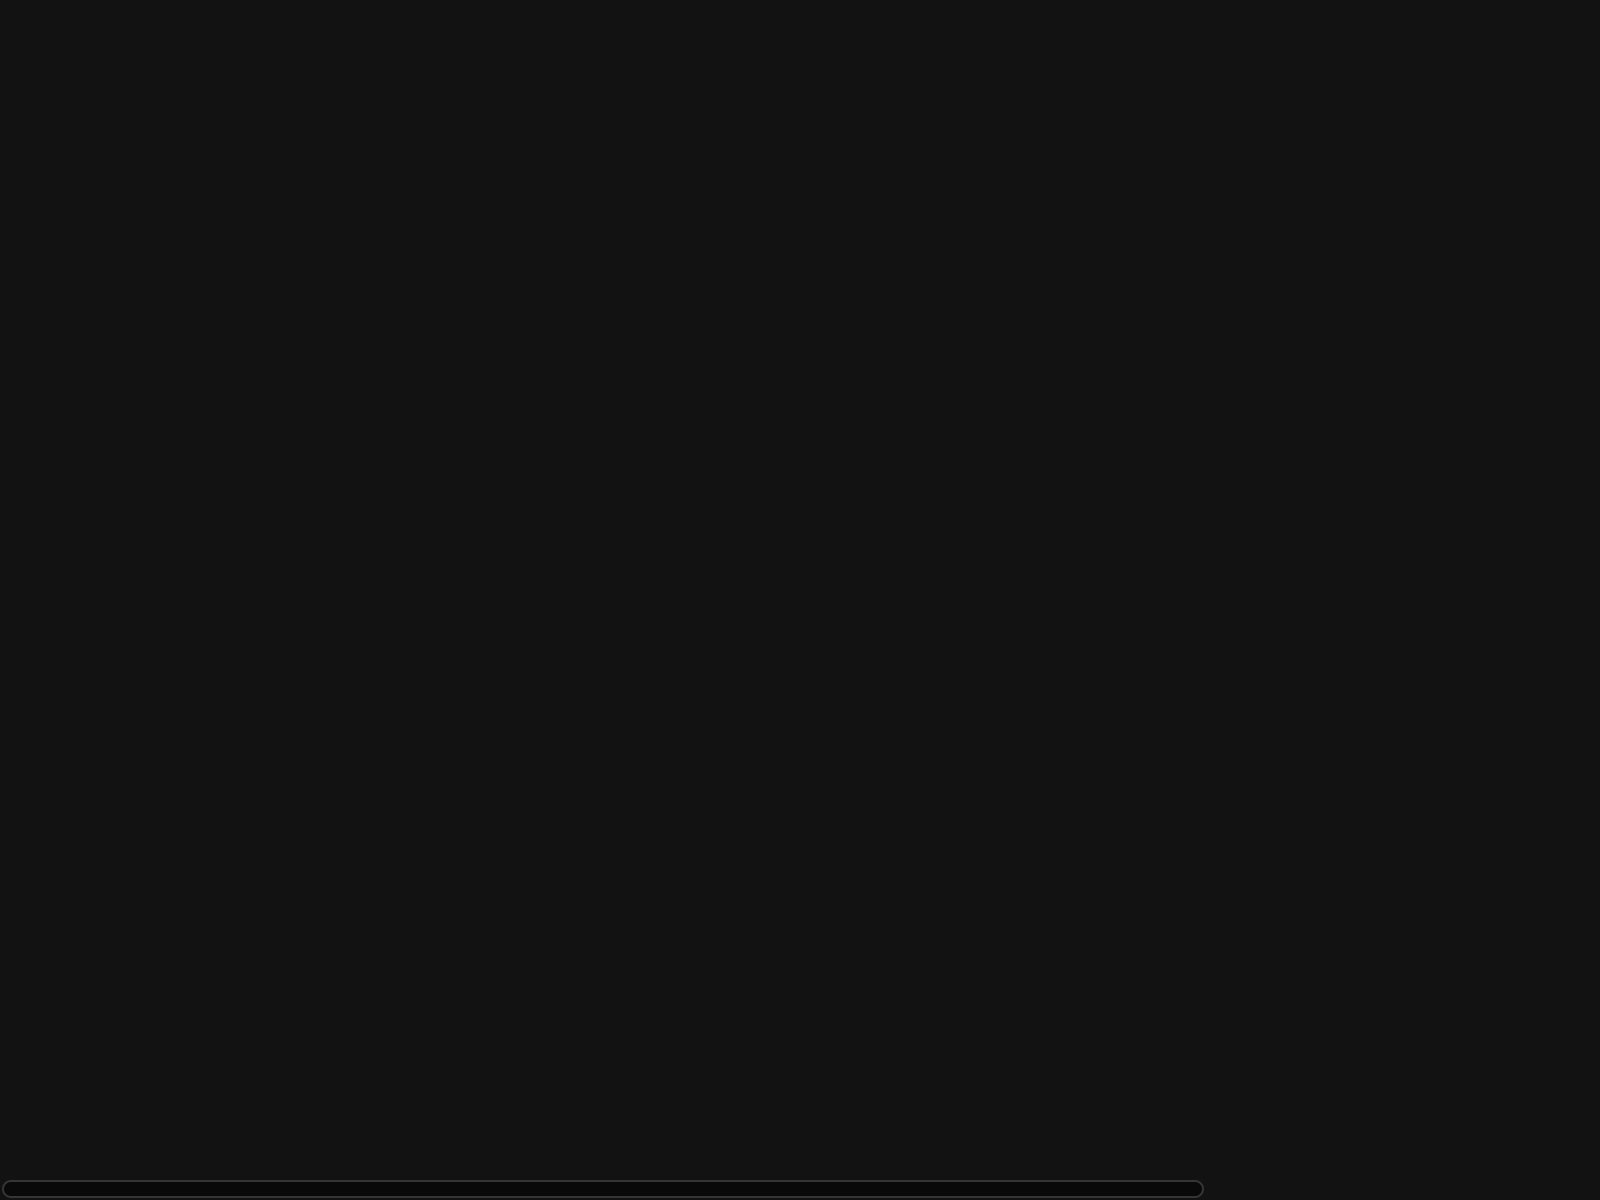

In [11]:
import os
import requests
url = "https://giphy.com/gifs/26uf6iTwBsFJFX6PS"
rep = requests.get(url)
# Write raw html to a file and open it with Selenium
with open("temp.html", "w") as f:
    f.write(rep.text)
driver.get("file://" + os.path.abspath('temp.html'))
Image(data=driver.get_screenshot_as_png())

Wow, complete darkness. It's beacause almost all pages of GIPHY are JavaScript rendered. Let's use Splash to render the raw response and see what it look like. 

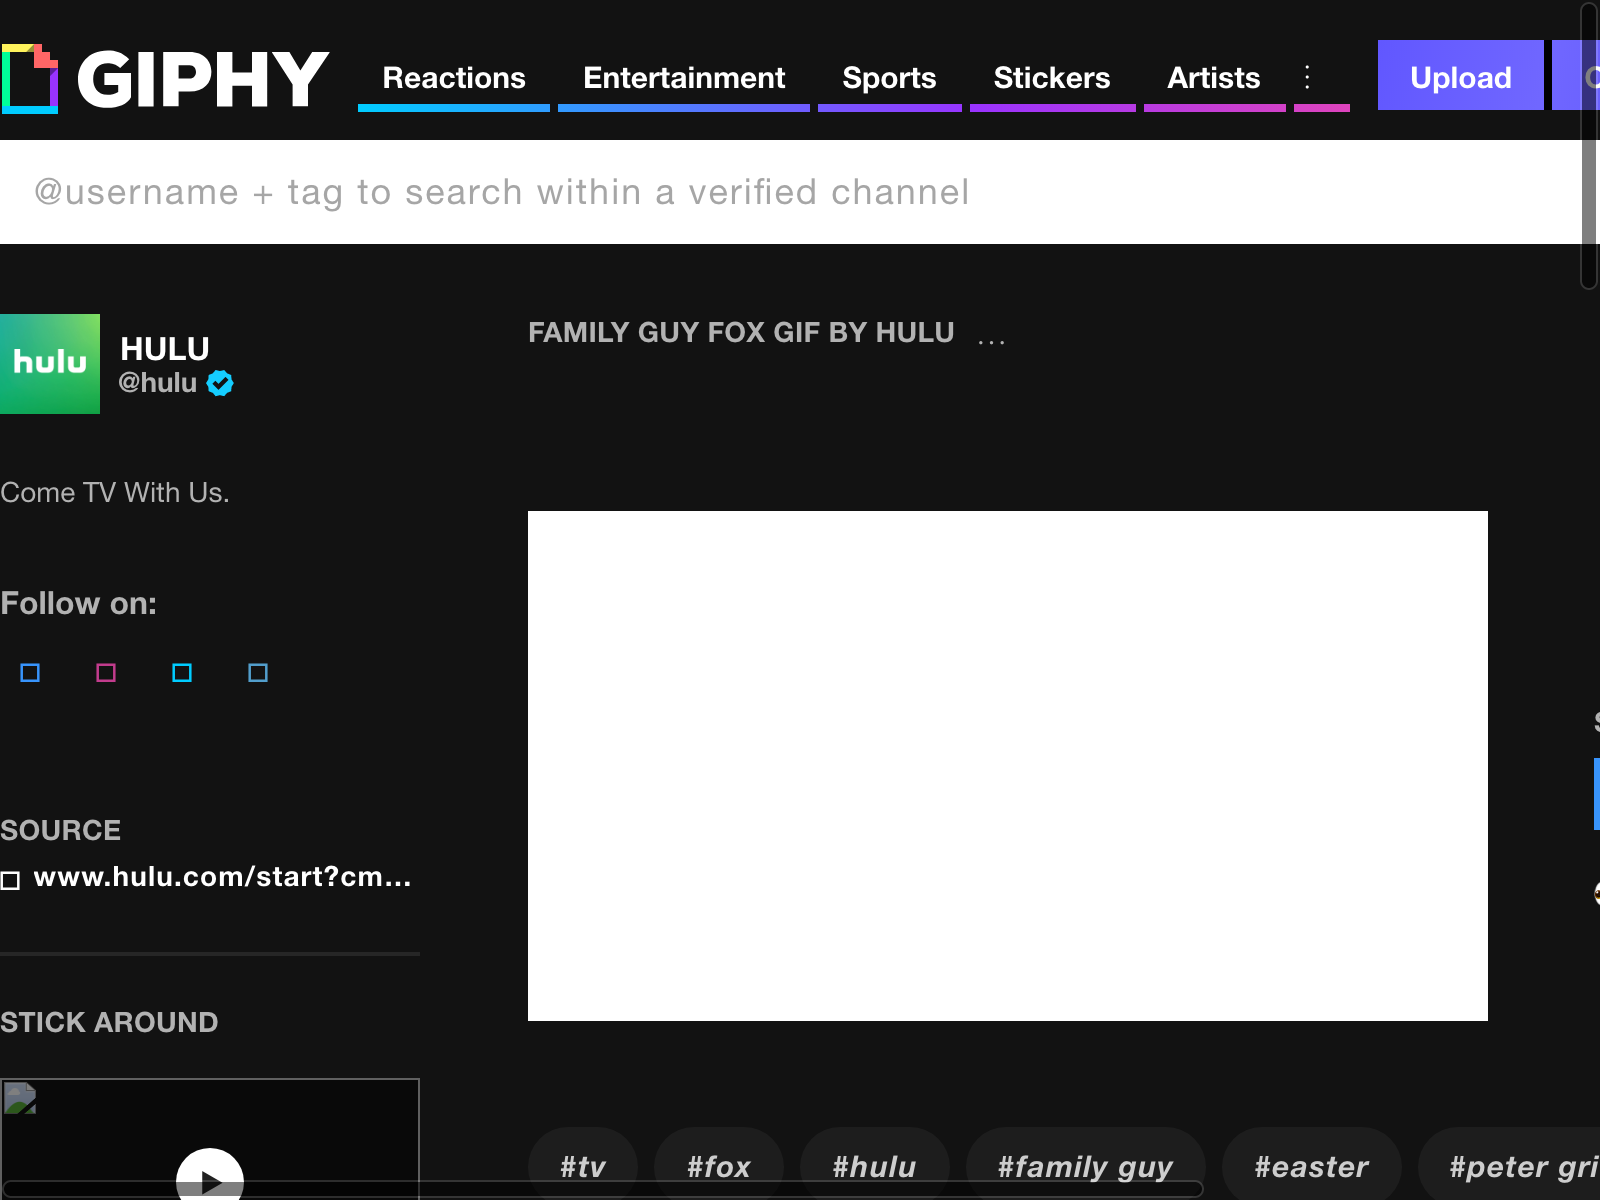

In [12]:
rep = requests.get("http://localhost:8050/render.html", params={'url':url})
with open("temp.html", "w") as f:
    f.write(rep.text)
driver.get("file://" + os.path.abspath('temp.html'))
Image(data=driver.get_screenshot_as_png())

We can see almost all elements are displayed properly. Some images cannot be loaded because we put HTML code to a local file, so the relative urls don't work.

In the end, let's clean up.

In [13]:
driver.close()
os.remove('temp.html')

## Crawling Name

Ler's use Scrapy and Splash to crawl the names of our target data. Scrapy is a popular crwaler framework which you can use it to implement your crawler quickly. Our spider is very simple, visit GIF pages of GIFs we already have ids and tags, and extract their names. 

In [14]:
import scrapy
import scrapy_splash
from scrapy_splash import SplashRequest

# Global variable to store crawling names
# Usually we store crawling data into databases or files, but it's fine to store results in memory for our task
gif_name_dict = {}

class GiphyNameSpider(scrapy.Spider):
    name = "GiphyName"
    
    custom_settings = {
        # Some required settings for Scrapy-Splash
        # Ref: https://github.com/scrapy-plugins/scrapy-splash#configuration
        'SPLASH_URL' : 'http://localhost:8050',
        'DOWNLOADER_MIDDLEWARES' : {
            'scrapy_splash.SplashCookiesMiddleware': 723,
            'scrapy_splash.SplashMiddleware': 725,
            'scrapy.downloadermiddlewares.httpcompression.HttpCompressionMiddleware': 810,
        },
        'SPIDER_MIDDLEWARES' : {
            'scrapy_splash.SplashDeduplicateArgsMiddleware': 100,
        },
        'DUPEFILTER_CLASS' : 'scrapy_splash.SplashAwareDupeFilter',
        'HTTPCACHE_STORAGE' : 'scrapy_splash.SplashAwareFSCacheStorage',
    }
    
    def __init__(self, urls, *args, **kwargs):
        super(GiphyNameSpider, self).__init__(*args, **kwargs)
        # For our case, we just want to crawl names of we already have ids
        # So we just need crawl names from their GIF pages
        self.start_urls = urls
    
    def start_requests(self):
        for url in self.start_urls:
            # Parameter url is the target url 
            # Parameter self.parse is the callback function when the request is downloaded 
            yield SplashRequest(url, self.parse,
            # These parameters are for Splash
            # Actually SplashRequest is like a wrapper for Splash HTTP API
                args={
                    'wait': 0.5,
                },
                endpoint='render.html',
                slot_policy=scrapy_splash.SlotPolicy.PER_DOMAIN,
            )
    
    def parse(self, response):
        gif_id = response.url.split('-')[-1].split('/')[-1]
        # Using inspector to figure out XPath of name tag
        # One thing you may notice is that the name of a GIF is in the title of the GIF page
        # So we don't have to use Splash here, but it's not the point :)
        gif_name = response.selector.xpath('//div[@class="gif-detail-page"]//h1/text()').extract()[0]
        global gif_name_dict
        gif_name_dict[gif_id] = gif_name
        # If you yield Scrapy Requests or SplashRequests in this function, Scrapy will handle them
        # (It's more like how a common crawler works)
        # But for our case, we don't need to do it

In [15]:
from scrapy.crawler import CrawlerProcess

# Generate urls of GIF pages of GIFs we already have ids 
crawl_urls = list(map(lambda x: 'https://giphy.com/gifs/' + x['id'], crawl_data))

process = CrawlerProcess()
# Parameter crawl_urls will be passed to __init__ of our crawler
process.crawl(GiphyNameSpider, crawl_urls)
process.start()

2018-04-01 19:35:37 [scrapy.utils.log] INFO: Scrapy 1.5.0 started (bot: scrapybot)
2018-04-01 19:35:37 [scrapy.utils.log] INFO: Versions: lxml 4.1.0.0, libxml2 2.9.4, cssselect 1.0.3, parsel 1.4.0, w3lib 1.19.0, Twisted 17.9.0, Python 3.6.3 |Anaconda, Inc.| (default, Oct  6 2017, 12:04:38) - [GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)], pyOpenSSL 17.2.0 (OpenSSL 1.0.2l  25 May 2017), cryptography 2.0.3, Platform Darwin-17.2.0-x86_64-i386-64bit
2018-04-01 19:35:37 [scrapy.crawler] INFO: Overridden settings: {'DUPEFILTER_CLASS': 'scrapy_splash.SplashAwareDupeFilter', 'HTTPCACHE_STORAGE': 'scrapy_splash.SplashAwareFSCacheStorage'}
2018-04-01 19:35:37 [scrapy.middleware] INFO: Enabled extensions:
['scrapy.extensions.corestats.CoreStats',
 'scrapy.extensions.telnet.TelnetConsole',
 'scrapy.extensions.memusage.MemoryUsage',
 'scrapy.extensions.logstats.LogStats']
2018-04-01 19:35:37 [scrapy.middleware] INFO: Enabled downloader middlewares:
['scrapy.downloadermiddlewares.httpau

2018-04-01 19:36:13 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://giphy.com/gifs/3osxYeICqP2rVF0nHa via http://localhost:8050/render.html> (referer: None)
2018-04-01 19:36:13 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://giphy.com/gifs/3og0ItVm74V5SO2zTi via http://localhost:8050/render.html> (referer: None)
2018-04-01 19:36:13 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://giphy.com/gifs/l2QZWjxLhm3CLOBBm via http://localhost:8050/render.html> (referer: None)
2018-04-01 19:36:15 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://giphy.com/gifs/vRMp7CmaghGQtElfsZ via http://localhost:8050/render.html> (referer: None)
2018-04-01 19:36:15 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://giphy.com/gifs/l0MrFtKDqikJbfEME via http://localhost:8050/render.html> (referer: None)
2018-04-01 19:36:15 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://giphy.com/gifs/l41lX93wGg6wwl5Bu via http://localhost:8050/render.html> (referer: None)
2018-04-01 19:36:17

2018-04-01 19:36:45 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://giphy.com/gifs/xUOwGotOjdXt4tgkFO via http://localhost:8050/render.html> (referer: None)
2018-04-01 19:36:45 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://giphy.com/gifs/2YsfNB6LzWfxg8mkBB via http://localhost:8050/render.html> (referer: None)
2018-04-01 19:36:48 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://giphy.com/gifs/3ohs4CBvqXRWQt6ClO via http://localhost:8050/render.html> (referer: None)
2018-04-01 19:36:48 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://giphy.com/gifs/FsW0PLcddc0pUZWsjO via http://localhost:8050/render.html> (referer: None)
2018-04-01 19:36:48 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://giphy.com/gifs/3LyZBPN2iv76muaPlu via http://localhost:8050/render.html> (referer: None)
2018-04-01 19:36:48 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://giphy.com/gifs/nqkQc1X3Hsp9UZiuAT via http://localhost:8050/render.html> (referer: None)
2018-04-01 19:36

We have names of GIFs, let's combine them with previous data.

In [16]:
for gif in crawl_data:
    gif['name'] = gif_name_dict[gif['id']]
print(crawl_data[:10])

[{'id': 'hTDNwZbCwOfrmUItSU', 'tags': ['love', 'animation', 'cute', 'cartoon', 'jump', 'animal', 'drawing', 'bunny', 'rabbit', 'spring', 'easter', 'hearts', 'hop', 'easter bunny'], 'name': 'Easter Bunny Love GIF by Gottalotta'}, {'id': 'SiGHSINUWUUDKnzYKI', 'tags': ['funny', 'lol', 'laughing', 'chicken', 'lmao', 'easter', 'joke', 'egg', 'chick', 'crack', 'chocron', 'crack up'], 'name': 'Crack Up Lol GIF by alexchocron'}, {'id': 'NQURqeViHYGTPHdbb3', 'tags': ['happy', 'animated', 'loop', 'bunny', 'easter', 'chicks', 'joonasjoonas', 'estinkg'], 'name': 'Happy Loop GIF by joonasjoonas'}, {'id': 'l2R00wfa8fttlpRPG', 'tags': ['dance', 'happy', 'easter', 'egg', 'april', 'happy easter', 'easter egg', 'lisa vertudaches', 'long weekend', 'easter sunday', 'chocolate egg', 'painted egg', 'easter excitement'], 'name': 'Happy Easter Sunday GIF by Lisa Vertudaches'}, {'id': '3osxYlGmgVHXNYtVWo', 'tags': ['gif', 'cute', 'bunny', 'easter', 'eggs', 'happy easter', 'easter bunny', 'storks', 'cute gif', 

## Summary

In this tutorial, we cover some strightforward technologies about crawlers. By using these tools, it's very strightforwad to crawl data you want, it's like you are a hunter, you direct your hounds, "preies is there! go and catch it!". You can develop your crawlers quickly with these technologies, but a shortcoming is that it might be inefficient due to involving too much JavaScript works. So if your scenario need high performance, you need to do some traffics analysis about AJXA requests to find data APIs to avoid rendering JavaScript. It's a laborious job and needs some skills and tricks. So you may need do a tradeoff between performance and development speed. 